##  關聯式規則(Association Rules)


---
1. 資料及套件讀取
2. 利用 apriori 演算法建立關聯規則
3. 視覺化我們的規則
4. 總結
5. Reference
---

### 1.資料及套件讀取

這裡拿網路上一個顧客購物公開資料，來進行分析，資料載點如下。

Source: UCI -- Online Retail

https://archive.ics.uci.edu/ml/datasets/online+retail

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
import csv
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

讀取檔案

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


查看個國家的購買數量

In [4]:
df["Country"].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [5]:
df.shape

(541909, 8)

資料清理

In [6]:
df['Description'] = df['Description'].str.strip()
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
# 去除退貨記錄
df = df[~df['InvoiceNo'].str.contains('C')]

只採用法國的購買紀錄，依發票及品名小計購買數量

結果是一個很大的稀疏矩陣(Sparse Matrix)

In [7]:
basket_fr = (df[df['Country']=="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket_fr.head(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537468,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


購物籃分析不考慮數量，將數量>0的值全部轉為1

In [8]:
def sum_to_boolean(x):
    if x<=0:
        return 0
    else:
        return 1
basket_fr_final = basket_fr.applymap(sum_to_boolean)
basket_fr_final.head(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537468,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df = basket_fr_final
df.shape

(392, 1563)

轉換成每一個 row 都是個別的購買紀錄，True代表有買此產品，False則反之，也可看出總共有 9835 筆購買紀錄， 169 筆商品

### 2. 利用 apriori 演算法建立關聯規則

還記得apriori演算法是怎麼運作的嗎？我們需要設定：

支持度(min support)：「規則」在資料內具有普遍性，也就是這些 A 跟 B 同時出現的機率多少。

信賴度(min confidence)：「規則」要有一定的信心水準，也就是當購買 A 狀態下，也會購買 B 的條件機率。

說明：

RULE: A->B

support = P(A^B) 普遍性

cofidence = P(B|A) 可靠性

lift = P(B|A) / P(B) 有效性


In [10]:
freq_item = apriori(df, min_support=0.06,use_colnames=True)

In [11]:
freq_item.head(10)

,support,itemsets
0,0.071429,(4 TRADITIONAL SPINNING TOPS)
1,0.096939,(ALARM CLOCK BAKELIKE GREEN)
2,0.102041,(ALARM CLOCK BAKELIKE PINK)
3,0.094388,(ALARM CLOCK BAKELIKE RED)
4,0.068878,(ASSORTED COLOUR MINI CASES)
5,0.081633,(BAKING SET 9 PIECE RETROSPOT)
6,0.068878,(CHARLOTTE BAG APPLES DESIGN)
7,0.066327,(CHARLOTTE BAG DOLLY GIRL DESIGN)
8,0.066327,(CHILDRENS APRON SPACEBOY DESIGN)
9,0.071429,(CHILDRENS CUTLERY DOLLY GIRL)


這裡列出了前十名普遍的購買組合

In [12]:
rules = association_rules(freq_item, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
4,(POSTAGE),(ALARM CLOCK BAKELIKE GREEN),0.765306,0.096939,0.084184,0.110000,1.134737,0.009996,1.014676
...,...,...,...,...,...,...,...,...,...
197,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...","(SET/6 RED SPOTTY PAPER CUPS, POSTAGE)",0.102041,0.117347,0.081633,0.800000,6.817391,0.069658,4.413265
198,(SET/6 RED SPOTTY PAPER CUPS),"(POSTAGE, SET/20 RED RETROSPOT PAPER NAPKINS, ...",0.137755,0.084184,0.081633,0.592593,7.039282,0.070036,2.247913
199,(POSTAGE),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.765306,0.099490,0.081633,0.106667,1.072137,0.005493,1.008034
200,(SET/20 RED RETROSPOT PAPER NAPKINS),"(SET/6 RED SPOTTY PAPER CUPS, POSTAGE, SET/6 R...",0.132653,0.102041,0.081633,0.615385,6.030769,0.068097,2.334694


設定完 min support 及 min confidence，有許多的規則符合我們的要求，但太多的資料對於決策上反而幫助不大，要怎麼挑選出對決策者重要的規則 (熱門 or 冷門 or 特定商品)，都可以利用同樣的概念，去找地想要的商品組合

這裡我們避免規則都找出大眾商品，並且想找出可靠性特別高的，及有效性非常高的商品組合，所以特別關注看 confidence / lift > 90 % 相對 support > 40 % 即可

In [13]:
rules.quantile(0.3)[["support","confidence","lift"]]

support       0.068878
confidence    0.500000
lift          1.143333
Name: 0.3, dtype: float64

In [14]:
rules.quantile(0.9)[["support","confidence","lift"]]

support       0.114796
confidence    0.896182
lift          7.602424
Name: 0.9, dtype: float64

In [15]:
int_rules = rules[(rules["support"]>0.06) &(rules["confidence"]>=0.89) &(rules["lift"]>=7.6)].sort_values(by=["lift"], ascending=False)
int_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.068878,0.071429,0.063776,0.925926,12.962963,0.058856,12.535714
15,(CHILDRENS CUTLERY DOLLY GIRL),(CHILDRENS CUTLERY SPACEBOY),0.071429,0.068878,0.063776,0.892857,12.962963,0.058856,8.690476
182,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959
188,"(SET/6 RED SPOTTY PAPER CUPS, POSTAGE, SET/20 ...",(SET/6 RED SPOTTY PAPER PLATES),0.084184,0.127551,0.081633,0.969697,7.602424,0.070895,28.790816


總共有 4 條符合我們設定的條件

可以看出是較冷門且兩者產品相關性高(相當類似的產品)

### 3. 視覺化我們的規則

3.1 scatter plot

Text(0, 0.5, 'confidence')

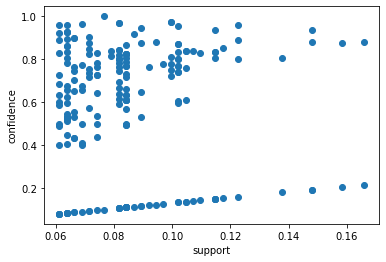

In [16]:
plt.scatter(rules["support"],rules["confidence"])
plt.xlabel("support")
plt.ylabel("confidence")

Text(0, 0.5, 'lift')

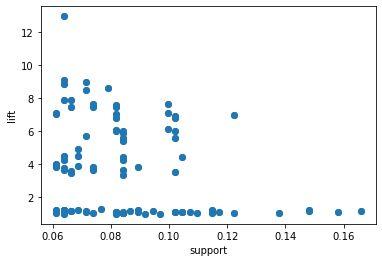

In [17]:
plt.scatter(rules["support"],rules["lift"])
plt.xlabel("support")
plt.ylabel("lift")

Text(0, 0.5, 'lift')

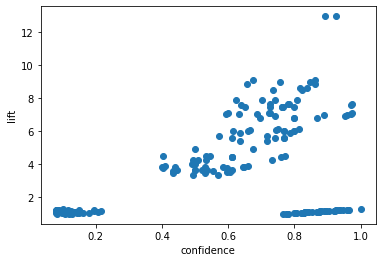

In [18]:
plt.scatter(rules["confidence"],rules["lift"])
plt.xlabel("confidence")
plt.ylabel("lift")

透過 scatter plot 可以了解這筆資料中的產品組合相關比較數值是如何分布的，也可以看出是否有特別的離群值，可能可以了解離群值是不是特別的商品組合，幫助我們做決策

3.2 網狀圖

利用網狀圖可以更視覺化的了解的同產品之間的關係

In [19]:
new_rules = rules.copy()
new_rules["antecedents"] = rules["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
new_rules["consequents"] = rules["consequents"].apply(lambda x: ', '.join(list(x))).astype("unicode")

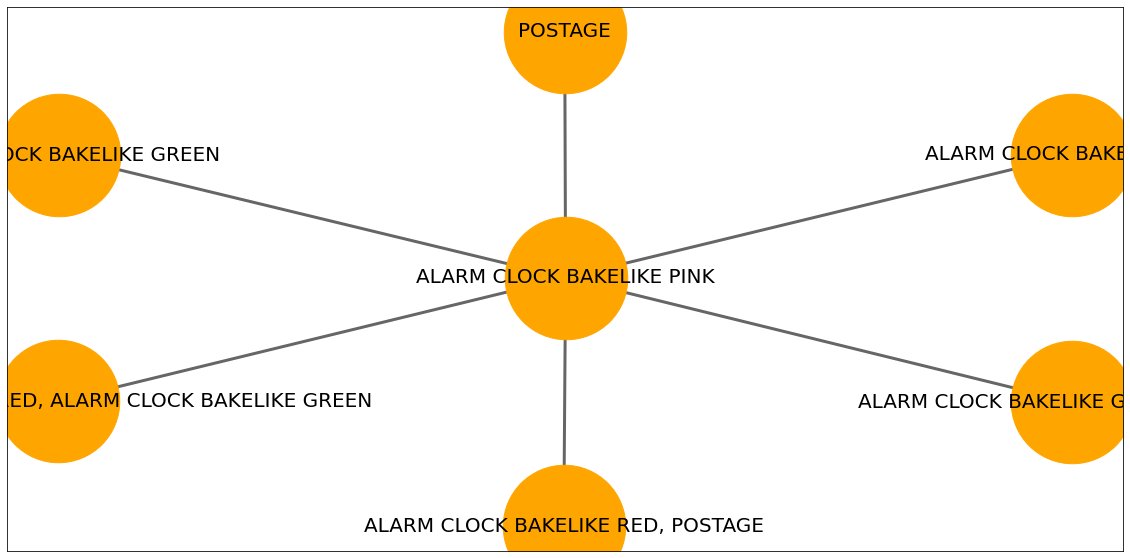

In [ ]:
import networkx as nx
fig, ax=plt.subplots(figsize=(20,10))
GA=nx.from_pandas_edgelist(new_rules[new_rules["antecedents"]=="ALARM CLOCK BAKELIKE PINK"],source='antecedents',target='consequents')
pos = nx.spring_layout(GA)
nx.draw_networkx_nodes(GA, pos, node_size = 15000, node_color = "orange")
nx.draw_networkx_edges(GA, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(GA, pos, font_size = 20, font_family = 'sans-serif')
#nx.draw(GA,with_labels=True)
plt.show()

針對單一有興趣的商品可以透過視覺化了解哪些商品與他的關聯性較大

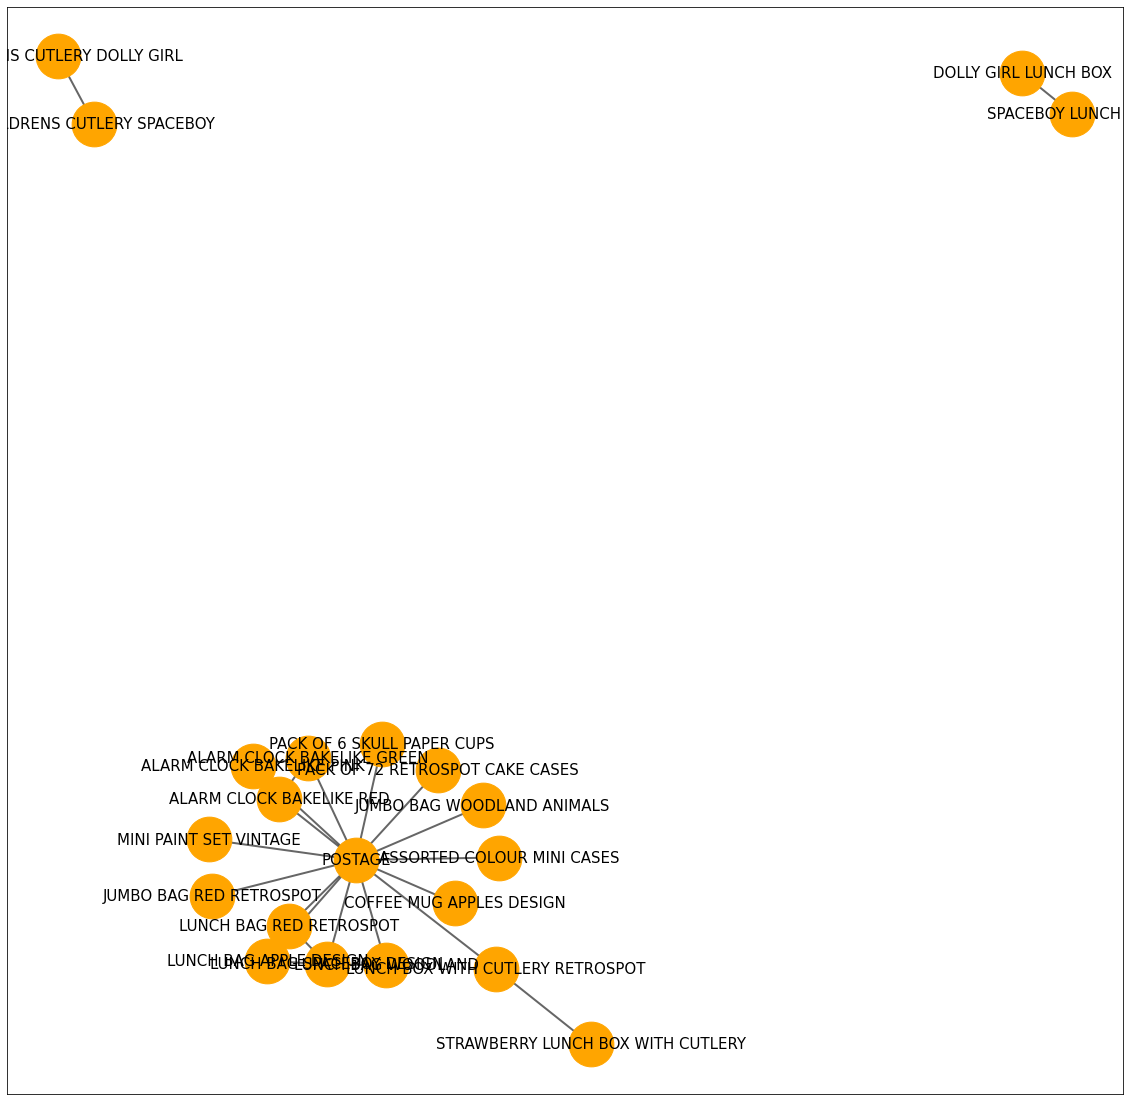

In [ ]:
import networkx as nx
fig, ax=plt.subplots(figsize=(20,20))
GA=nx.from_pandas_edgelist(new_rules.head(50),source='antecedents',target='consequents')
pos = nx.spring_layout(GA)
nx.draw_networkx_nodes(GA, pos, node_size = 2000, node_color = "orange")
nx.draw_networkx_edges(GA, pos, width = 2, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(GA, pos, font_size = 15, font_family = 'sans-serif')
#nx.draw(GA,with_labels=True)
plt.show()

以上是針對最一開始挑選出來的前50名的規則畫圖，可以看出有些產品的關聯性較大，有些則較遠，呈現分群的現象，可能可以代表不同的購買客群

In [ ]:
int_rules["antecedents"] = int_rules["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
int_rules["consequents"] = int_rules["consequents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
int_rules = int_rules.assign(antecedents=int_rules['antecedents'].str.split(',')).explode('antecedents')
int_rules = int_rules.assign(consequents=int_rules['consequents'].str.split(',')).explode('consequents')
int_rules = int_rules.reset_index().drop(["index"], axis=1)

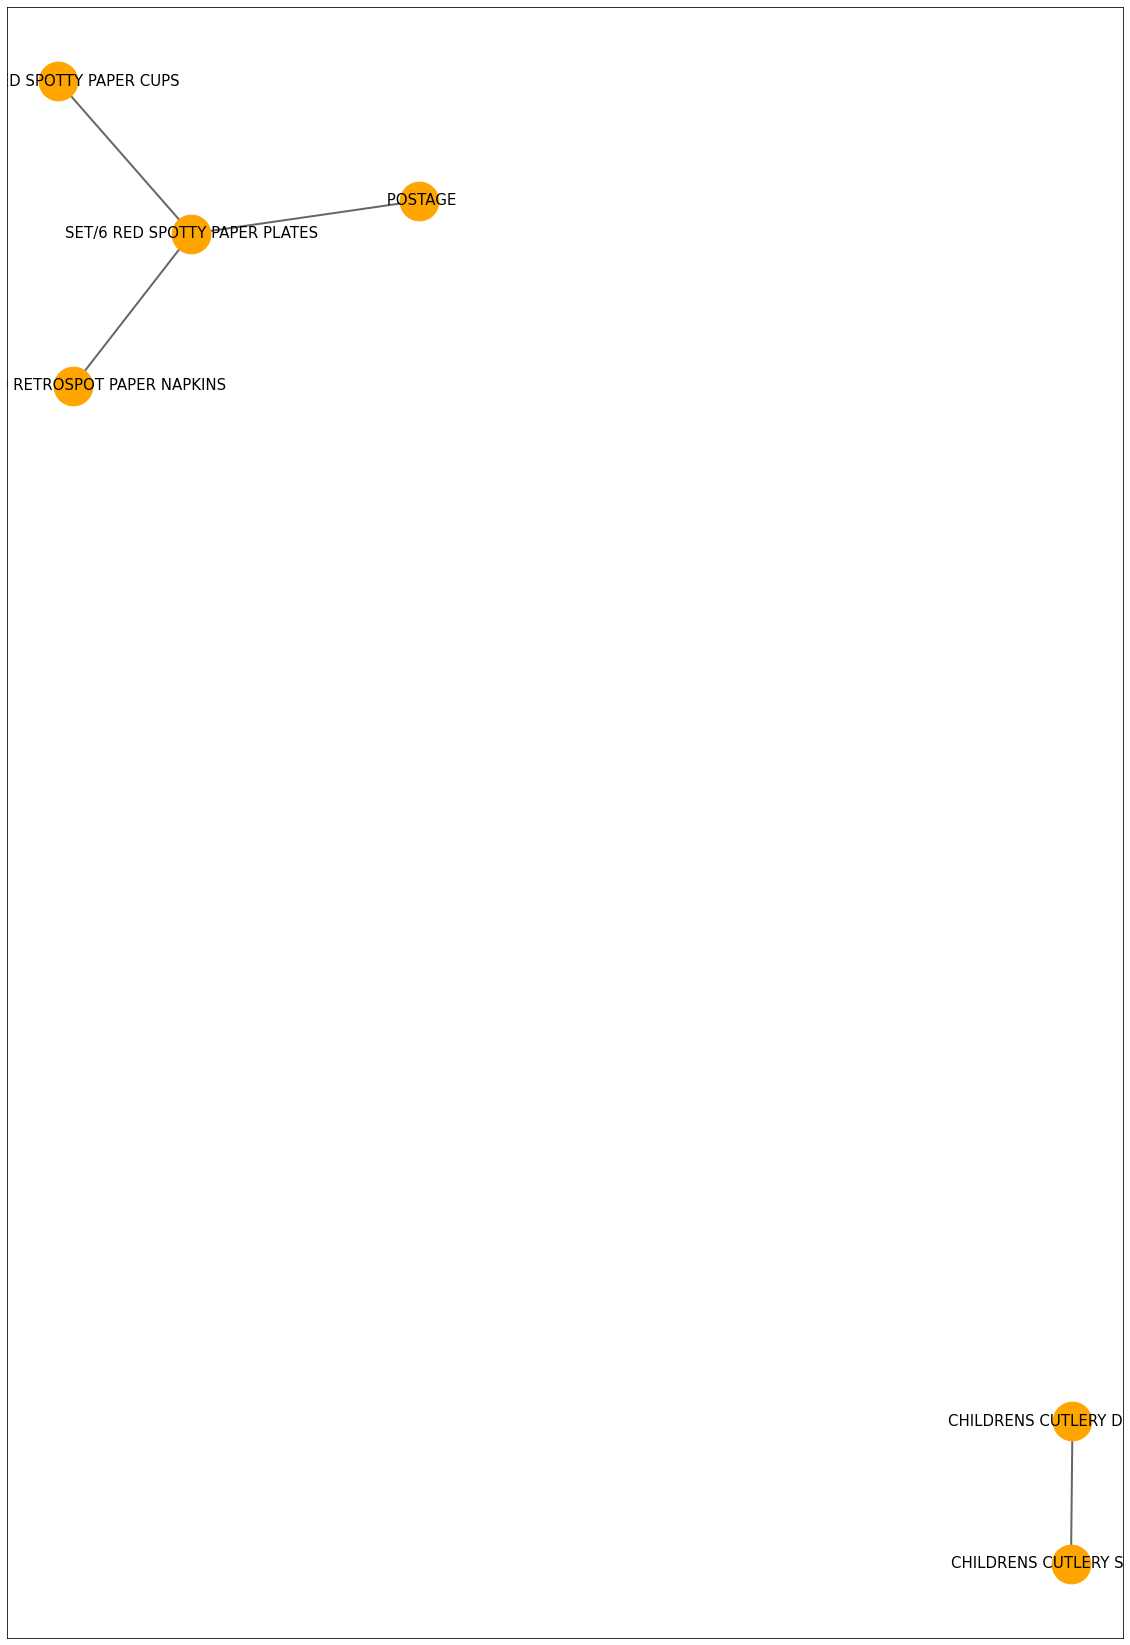

In [ ]:
import networkx as nx
fig, ax=plt.subplots(figsize=(20,30))
GA=nx.from_pandas_edgelist(int_rules,source='antecedents',target='consequents')
pos = nx.spring_layout(GA)
nx.draw_networkx_nodes(GA, pos, node_size = 1500, node_color = "orange")
nx.draw_networkx_edges(GA, pos, width = 2, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(GA, pos, font_size = 15, font_family = 'sans-serif')
#nx.draw(GA,with_labels=True)
plt.show()

以上是我們根據我們設定的數值下取出的4條規則

### 4. 總結

和一些機器學習方法只會專注在「預測準確率」的概念不太一樣，，關聯式規則在「解釋」上具有十分強大的優勢。

的確，在現實中，有時候確實只要「高的預測準確率」的模型，就可以達成許多目標。

可是也千萬別忘記了，我們正在進行的是「資料分析」，也就是去「解釋」資料中的故事。

事實上，有時候這個步驟反而會比「準確率」還重要。這一點，稍微思考一下就能理解了：唯有去探討資料的故事，才有機會發現到有趣的跡象、失敗的原因、違背直覺的現象……等等。

而且，這樣才有一種……真正在進行「資料分析」的感覺，不是嗎？

#### 延伸問題

1. 試著思考關聯規則除了用在購買紀錄外，還可以用在哪樣的資料任務當中
2. 比較決策樹與關聯規則的差異，兩者有哪些相同的與不相同的地方

### 5. Reference

https://docs.microsoft.com/en-us/archive/msdn-magazine/2018/december/artificially-intelligent-market-basket-analysis

https://pbpython.com/market-basket-analysis.html

https://www.rpubs.com/skydome20/R-Note6-Apriori-DecisionTree

MDS 課堂講義